In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN as skDBSCAN
from cuml import DBSCAN as cumlDBSCAN
import cudf
import os

In [2]:
from timeit import default_timer

class Timer(object):
    def __init__(self):
        self._timer = default_timer
    
    def __enter__(self):
        self.start()
        return self

    def __exit__(self, *args):
        self.stop()

    def start(self):
        """Start the timer."""
        self.start = self._timer()

    def stop(self):
        """Stop the timer. Calculate the interval in seconds."""
        self.end = self._timer()
        self.interval = self.end - self.start

In [3]:
eps = .3
min_samples = 2

In [4]:
import numpy as np
import pandas as pd
import cudf
import numba
from librmm_cffi import librmm as rmm
from numba.cuda.cudadrv.driver import driver
import math
from numba import cuda

def row_matrix(df):
    # matrix = rmm.device_array(shape=(nrow, ncol), dtype=dtype, order='C')
    # for colidx, col in enumerate(cols):
    #     gpu_row_matrix.forall(matrix[:, colidx].size)(matrix[:, colidx],
    #                                                   col.to_gpu_array(),
    #                                                   nrow, ncol)
    """Compute the C (row major) version gpu matrix of df

    This implements the algorithm documented in
    http://devblogs.nvidia.com/parallelforall/efficient-matrix-transpose-cuda-cc/

    :param a: an `np.ndarray` or a `DeviceNDArrayBase` subclass. If already on
        the device its stream will be used to perform the transpose (and to copy
        `b` to the device if necessary).

    Adapted from numba:
    https://github.com/numba/numba/blob/master/numba/cuda/kernels/transpose.py
    """

    print("STARTING")

    cols = [df._cols[k] for k in df._cols]
    ncol = len(cols)
    nrow = len(df)
    dtype = cols[0].dtype

    a = df.as_gpu_matrix(order='F')
    b = rmm.device_array((nrow, ncol), dtype=dtype, order='C')
    dtype = numba.typeof(a)

    tpb = driver.get_device().MAX_THREADS_PER_BLOCK

    tile_width = int(math.pow(2, math.log(tpb, 2) / 2))
    tile_height = int(tpb / tile_width)

    tile_shape = (tile_height, tile_width + 1)

    @cuda.jit
    def kernel(input, output):

        tile = cuda.shared.array(shape=tile_shape, dtype=numba.float32)

        tx = cuda.threadIdx.x
        ty = cuda.threadIdx.y
        bx = cuda.blockIdx.x * cuda.blockDim.x
        by = cuda.blockIdx.y * cuda.blockDim.y
        y = by + tx
        x = bx + ty

        if by + ty < input.shape[0] and bx + tx < input.shape[1]:
            tile[ty, tx] = input[by + ty, bx + tx]
        cuda.syncthreads()
        if y < output.shape[0] and x < output.shape[1]:
            output[y, x] = tile[tx, ty]

    # one block per tile, plus one for remainders
    blocks = int(b.shape[1] / tile_height + 1), int(b.shape[0] / tile_width + 1)
    # one thread per tile element
    threads = tile_height, tile_width
    kernel[blocks, threads](a, b)

    print("ANSWER: " + str(b.device_ctypes_pointer))

    return b


In [5]:
print('Dimensions: %s x %s' % (X.shape[0], X.shape[1]))
print('\n1st row', X[0])

NameError: name 'X' is not defined

In [6]:
np.savetxt(fname='/home/cjnolet/Desktop/images.csv', 
           X=X, delimiter=',', fmt='%d')
np.savetxt(fname='/home/cjnolet/Desktop/labels.csv', 
           X=y, delimiter=',', fmt='%d')

NameError: name 'X' is not defined

In [ ]:
cudf.read_csv

In [11]:
str(y)

'      y\n 0  5.0\n 1  0.0\n 2  4.0\n 3  1.0\n 4  9.0\n 5  2.0\n 6  1.0\n 7  3.0\n 8  1.0\n 9  4.0\n[59990 more rows]'

In [12]:
import umap
import matplotlib.pyplot as plt
reducer = umap.UMAP(random_state = 42)

In [13]:
embedding = reducer.fit_transform(np.asarray(row_matrix(X)))

STARTING
ANSWER: c_ulong(139871716900864)


In [14]:
embedding.shape

(60000, 2)

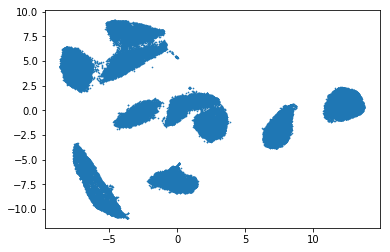

In [15]:
plt.scatter(embedding[:,0], embedding[:,1], s = 0.4)

In [5]:
X = cudf.read_csv("/home/cjnolet/Desktop/images.csv", 
                  names = [str(x) for x in range(784)], 
                  dtype=['float32' for x in range(784)])

y = cudf.read_csv("/home/cjnolet/Desktop/labels.csv", 
                  names = ["y"], 
                  dtype = ["float32"])

X_test = cudf.read_csv("/home/cjnolet/Desktop/images_test.csv", 
                       names = [str(x) for x in range(784)], 
                       dtype=['float32' for x in range(784)])

y_test = cudf.read_csv("/home/cjnolet/Desktop/labels_test.csv", 
                       names = ["y"], dtype = ["float32"])

In [6]:
%%time
from cuml import KNN
knn = KNN()
knn.fit(X)
Distances, Indices = knn.query(X, 5)
print(str(Distances))
print(str(Indices))

   distance_neighbor_0 distance_neighbor_1 distance_neighbor_2 distance_neighbor_3 distance_neighbor_4
 0                 0.0           2438196.0           2533195.0           2543129.0           2549481.0
 1                 0.0           1041721.0           1211165.0           1266715.0           1267181.0
 2                 0.0           1897866.0           2375073.0           2414374.0           2516009.0
 3                 0.0            176050.0            187550.0            200769.0            207112.0
 4                 0.0           1238553.0           1306472.0           1308161.0           1338140.0
 5                 0.0           2114950.0           2202622.0           2225104.0           2234103.0
 6                 0.0            306111.0            316190.0            319989.0            335356.0
 7                 0.0           1261394.0           1311640.0           1361250.0           1476435.0
 8                 0.0            184299.0            209882.0           

In [14]:
def vote(x):
    d = {}
    for i in x:
        d[i] = 1 if i not in d else d[i]+1
    return max(d, key=d.get)

def kNN_Classifier(kNN, X, labels, k, voting_function = vote):
    D, I = kNN.query(X, k)
    I = np.asarray(I.as_gpu_matrix())
    l = np.asarray(labels["y"].to_gpu_array())
    
    return cudf.DataFrame([("y_hat", [voting_function(l[int(i)] for i in I[j]) for j in range(len(I))])])

In [13]:
%%time
l = kNN_Classifier(knn, X_test, y, 2)

AttributeError: module 'numba.cuda' has no attribute 'DataFrame'

In [9]:
def calc_accuracy(y, y_hat):
    return 1 - (len(list(filter(lambda x: x[0] != x[1], zip(y, y_hat)))) / len(y_hat))

In [10]:
l

[7.0,
 2.0,
 1.0,
 0.0,
 4.0,
 1.0,
 4.0,
 9.0,
 5.0,
 9.0,
 0.0,
 6.0,
 9.0,
 0.0,
 1.0,
 5.0,
 9.0,
 7.0,
 3.0,
 4.0,
 9.0,
 6.0,
 6.0,
 5.0,
 9.0,
 0.0,
 7.0,
 4.0,
 0.0,
 1.0,
 3.0,
 1.0,
 3.0,
 0.0,
 7.0,
 2.0,
 7.0,
 1.0,
 2.0,
 1.0,
 1.0,
 7.0,
 4.0,
 2.0,
 3.0,
 5.0,
 1.0,
 2.0,
 4.0,
 4.0,
 6.0,
 3.0,
 5.0,
 5.0,
 6.0,
 0.0,
 4.0,
 1.0,
 9.0,
 5.0,
 7.0,
 8.0,
 9.0,
 3.0,
 7.0,
 9.0,
 6.0,
 4.0,
 3.0,
 0.0,
 7.0,
 0.0,
 2.0,
 9.0,
 1.0,
 7.0,
 3.0,
 2.0,
 9.0,
 7.0,
 7.0,
 6.0,
 2.0,
 7.0,
 8.0,
 4.0,
 7.0,
 3.0,
 6.0,
 1.0,
 3.0,
 6.0,
 9.0,
 3.0,
 1.0,
 4.0,
 1.0,
 7.0,
 6.0,
 9.0,
 6.0,
 0.0,
 5.0,
 4.0,
 9.0,
 9.0,
 2.0,
 1.0,
 9.0,
 4.0,
 8.0,
 7.0,
 3.0,
 9.0,
 7.0,
 9.0,
 4.0,
 4.0,
 9.0,
 2.0,
 5.0,
 4.0,
 7.0,
 6.0,
 7.0,
 9.0,
 0.0,
 5.0,
 8.0,
 5.0,
 6.0,
 6.0,
 5.0,
 7.0,
 8.0,
 1.0,
 0.0,
 1.0,
 6.0,
 4.0,
 6.0,
 7.0,
 3.0,
 1.0,
 7.0,
 1.0,
 8.0,
 2.0,
 0.0,
 2.0,
 9.0,
 9.0,
 5.0,
 5.0,
 1.0,
 5.0,
 6.0,
 0.0,
 3.0,
 4.0,
 4.0,
 6.0,
 5.0,
 4.0,
 6.0,
 5.0,
 4.0

In [12]:
calc_accuracy(l, y_test["y"])

0.9653

In [13]:
%%time
clustering_cuml = cumlDBSCAN(eps = avg_neighbor, min_samples = 2)
clustering_cuml.fit(X, row_matrix)
db = clustering_cuml

NameError: name 'avg_neighbor' is not defined

In [14]:
db = clustering_cuml

NameError: name 'clustering_cuml' is not defined

In [ ]:
labels = db.labels_
len(set(labels))

STARTING
ANSWER: c_ulong(139865340302336)


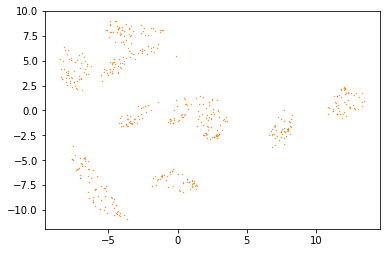

In [34]:
X = np.asarray(row_matrix(X))[0:500,:]

import matplotlib.pyplot as plt

db = clustering_cuml

# Black removed and is used for noise instead.
labels = db.labels_[0:500]
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    class_member_mask = (labels == k)
    
    c = X[labels == k]

    
    plt.plot(c[:,0], c[:,1], 'o', markerfacecolor=tuple(col), markersize=0.4)

In [35]:
plt.scatter(np.asarray(row_matrix(pca_t))[:,0], np.asarray(row_matrix(pca_t))[:,1], s = 0.7)

NameError: name 'pca_t' is not defined